In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 超参数设置
batch_size = 128
learning_rate = 0.01


# CIFAR-100数据集
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# CCNet模块的定义
class CrissCrossAttention(nn.Module):
    def __init__(self, in_dim):
        super(CrissCrossAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height)  # [B, C/8, N]
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)  # [B, C/8, N]
        energy = torch.bmm(proj_query.permute(0, 2, 1), proj_key)  # [B, N, N]
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)  # [B, C, N]

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))  # [B, C, N]
        out = out.view(batch_size, C, width, height)
        
        out = self.gamma * out + x
        return out

class PartialCCNetCNN(nn.Module):
    def __init__(self):
        super(PartialCCNetCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            CrissCrossAttention(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            CrissCrossAttention(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(256 * 4 * 4, 100)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

# 模型实例化，损失函数和优化器定义
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PartialCCNetCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# 学习率调整策略
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)



Files already downloaded and verified
Files already downloaded and verified


In [2]:
def train_and_evaluate(model, trainloader, testloader, num_epochs=10):


    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')
        scheduler.step()
     # 绘制损失和准确度曲线
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # 绘制训练损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练和测试准确度曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Test accuracy')
    plt.title('Training and Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Epoch [1/100], Loss: 4.6544, Train Accuracy: 11.60%, Test Accuracy: 18.08%
Epoch [2/100], Loss: 3.1666, Train Accuracy: 23.39%, Test Accuracy: 26.73%
Epoch [3/100], Loss: 2.7474, Train Accuracy: 31.45%, Test Accuracy: 33.09%
Epoch [4/100], Loss: 2.4710, Train Accuracy: 36.94%, Test Accuracy: 36.53%
Epoch [5/100], Loss: 2.2772, Train Accuracy: 41.25%, Test Accuracy: 41.44%
Epoch [6/100], Loss: 2.1361, Train Accuracy: 44.27%, Test Accuracy: 41.93%
Epoch [7/100], Loss: 2.0259, Train Accuracy: 46.54%, Test Accuracy: 43.25%
Epoch [8/100], Loss: 1.9329, Train Accuracy: 48.51%, Test Accuracy: 44.63%
Epoch [9/100], Loss: 1.8605, Train Accuracy: 50.50%, Test Accuracy: 45.15%
Epoch [10/100], Loss: 1.7987, Train Accuracy: 51.76%, Test Accuracy: 47.23%
Epoch [11/100], Loss: 1.7481, Train Accuracy: 52.76%, Test Accuracy: 48.71%
Epoch [12/100], Loss: 1.6949, Train Accuracy: 54.34%, Test Accuracy: 47.21%
Epoch [13/100], Loss: 1.6623, Train Accuracy: 54.60%, Test Accuracy: 47.19%
Epoch [14/100], Loss:

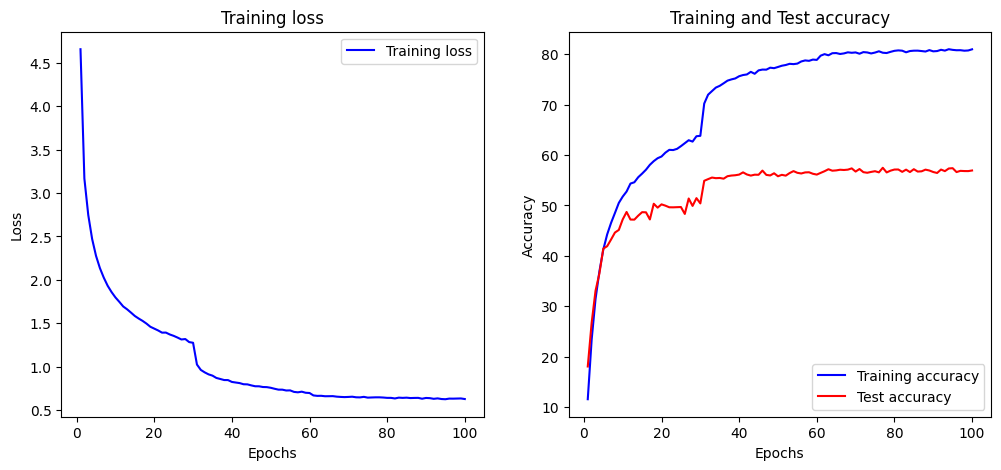

In [3]:
train_and_evaluate(model, trainloader, testloader, num_epochs=100)